# Object Detection with Faster R-CNN





## 1) Initial Tasks




In [ ]:
import torch
import os

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 2) Fetch Data



In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From: https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
To: /content/Face Mask Detection.zip
100% 417M/417M [00:04<00:00, 84.8MB/s]
Face Mask Detection.zip download complete!


In [ ]:
#Let's see an annotation file

path = "/content/annotations/"

files = os.listdir(path)

with open(os.path.join(path, files[0]), 'r') as file:
    annotation_file = file.read()
    print(annotation_file )



<annotation>
    <folder>images</folder>
    <filename>maksssksksss185.png</filename>
    <size>
        <width>400</width>
        <height>267</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>89</xmin>
            <ymin>139</ymin>
            <xmax>121</xmax>
            <ymax>187</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>115</xmin>
            <ymin>112</ymin>
            <xmax>139</xmax>
            <ymax>154</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</trun

## 3) Prepare Data






### 3.1) Split Data

In [ ]:
import random
import numpy as np
import shutil #for operating on files, directories, etc.

In [ ]:
#See data lengths before split
print("Length of annotations before split:", len(os.listdir('annotations')))
print("Length of images before split:",len(os.listdir('images')))
print()

#Create seperate file locations for the test set
!mkdir test_images
!mkdir test_annotations


#Set random seed - so that we'll have the same split every run
random.seed(1234)


#Split data via indexes
idx = random.sample(range(853), 170)
for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)
for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)


#See data lengths after split
print("Length of train annotations:", len(os.listdir('annotations')))
print("Length of train images:", len(os.listdir('images')))
print("Length of test annotations:", len(os.listdir('test_annotations')))
print("Length of test images:", len(os.listdir('test_images')))

Length of annotations before split: 853
Length of images before split: 853

Length of train annotations: 683
Length of train images: 683
Length of test annotations: 170
Length of test images: 170


### 3.2) Define MaskDetectionDataset Class



In [ ]:
from torchvision import transforms, datasets
from bs4 import BeautifulSoup #for web scraping, pulling data from XML & HTML files

In [ ]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [ ]:
adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":
        return 1 + adjust_label # Class with_mask now has label 2

    elif obj.find('name').text == "mask_weared_incorrect":
        return 2 + adjust_label # Class mask_worn_incorrectly now has label 3

    return adjust_label #Class without_mask now has label 1

In [ ]:
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects: # iterates over each <object> tag in the parsed content
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [ ]:
class MaskDetectionDataset(object):
    def __init__(self, transforms, path):
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path))) #for reproducibility &
                                                        #for consistent pairing with labels/bboxes

    def __getitem__(self, idx):
        file_image = self.imgs[idx] #filename of the image at index idx
        file_label = self.imgs[idx][:-3] + 'xml' #filename of the associated XML
                                                #removes last 3 characters, ie png
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB") #returns (R,G,B) - ex: (255,0,0) is red
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): #So that len() gives no of images, not no of objects
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = MaskDetectionDataset(data_transform, 'images/')
test_dataset = MaskDetectionDataset(data_transform, 'test_images/')

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

## 4) Understanding the Data



In [ ]:
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
def plot_images(images, predictions):
    # Define class name mapping
    class_name_mapping = {
        1: 'Without mask',
        2: 'With mask',
        3: 'Mask worn incorrectly'
    }

    #  normalization reversal
    mean = torch.Tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(1)
    std = torch.Tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(1)

    for img, prediction in zip(images, predictions):
        img_unnormalized = img.cpu() * std + mean
        # Convert tensor to numpy array and permute axes
        img_np = img_unnormalized.cpu().numpy().transpose(1, 2, 0)  # Change shape to (H, W, C)

        fig, ax = plt.subplots(1)
        ax.imshow(img_np)  # Now the images are in the right format to be displayed

        for idx in range(len(prediction["boxes"])):
            xmin, ymin, xmax, ymax = prediction["boxes"][idx].cpu().numpy()  # Transfer box tensor to CPU and convert to numpy
            label = int(prediction['labels'][idx].cpu().item())  # Convert tensor to integer after transferring to CPU
            class_name = f"{class_name_mapping.get(label, 'Unknown')}"
            color = None

            if label == 1:
                color = 'r'
            elif label == 2:
                color = 'g'
            elif label == 3:
                color = 'orange'

            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor=color, facecolor='none')
            ax.text(xmin, ymin, class_name, bbox=dict(facecolor=color, alpha=0.5), fontsize=8, color='white')
            ax.add_patch(rect)

        plt.show()


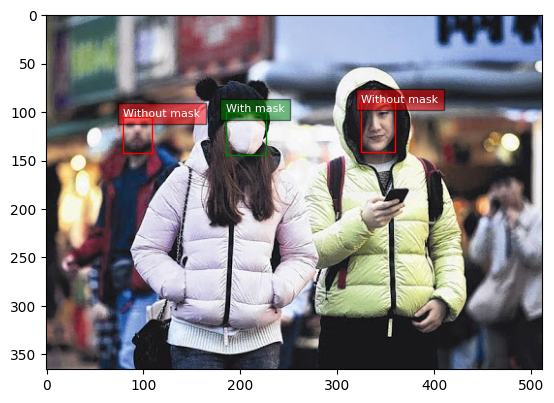

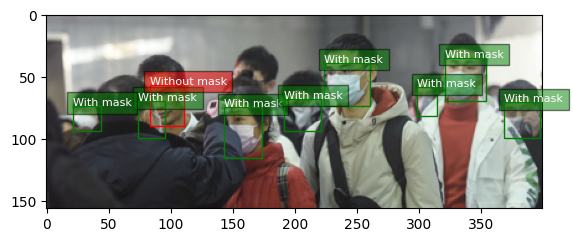

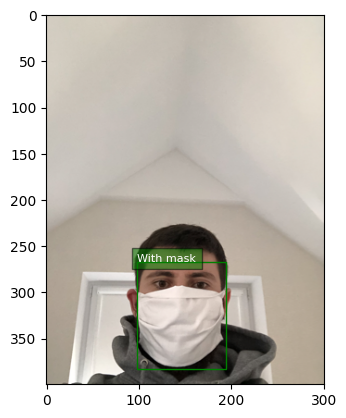

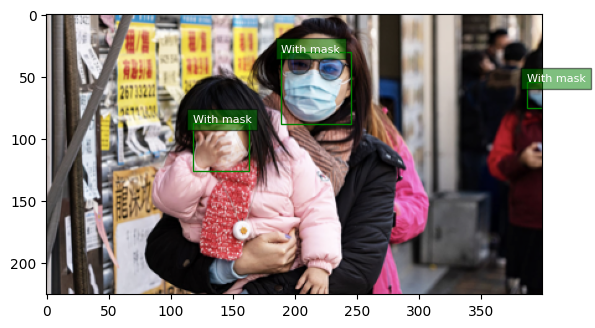

In [ ]:
images, annotations = next(iter(train_data_loader))
plot_images(images, annotations)

In [ ]:
class_counts = Counter()

for _, annotations in train_data_loader:
    for annotation in annotations:
        class_counts.update(annotation['labels'].numpy())

In [ ]:
class_counts

Counter({1: 532, 2: 2691, 3: 97})

## 5) Create Model

In [ ]:
import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
num_classes=4 #1 for the background class!

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        #we got the pretrained weights & the model structure

in_features = model.roi_heads.box_predictor.cls_score.in_features
        #no of input features to the classifier of ROI heads

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        #now the BBox Regressor of the ROI heads will detect BBoxes for 4 classes (was originally 91)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 121MB/s]


## 6) Train Model



In [ ]:
#move model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10

params = [p for p in model.parameters() if p.requires_grad]
#Parameters that the optimizer will backprop. on

optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
#weight_decay - prevents overfitting (by keeping the weights small)

In [ ]:
epoch_losses=[]
classifier_losses=[]
bbox_reg_losses=[]
obj_losses=[]
rpn_bbox_losses=[]

for epoch in range(num_epochs):
    print('----------------------Epoch ', epoch+1, '--------------------------', sep="")
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    classifier_loss=0
    bbox_reg_loss=0
    objectness_loss=0
    rpn_boxreg_loss=0
    for imgs, annotations in train_data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        classifier_loss += float(loss_dict["loss_classifier"])
        bbox_reg_loss += float(loss_dict["loss_box_reg"])
        objectness_loss += float(loss_dict["loss_objectness"])
        rpn_boxreg_loss += float(loss_dict["loss_rpn_box_reg"])
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses

    epoch_losses.append(epoch_loss)
    classifier_losses.append(classifier_loss)
    bbox_reg_losses.append (bbox_reg_loss)
    obj_losses.append(objectness_loss)
    rpn_bbox_losses.append(rpn_boxreg_loss)
    print(f'Epoch: {epoch+1}, Total Loss: {epoch_loss:.4f}, Classifier Loss: {classifier_loss:.4f}, ROI BBox Reg. Loss: {bbox_reg_loss:.4f}, Obj. Loss: {objectness_loss:.4f}, RPN BBox Reg. Loss: {rpn_boxreg_loss:.4f}, Run Time: {time.time() - start:.4f}')

----------------------Epoch 1--------------------------
Epoch: 1, Total Loss: 76.5135, Classifier Loss: 27.1936, ROI BBox Reg. Loss: 38.9794, Obj. Loss: 7.7484, RPN BBox Reg. Loss: 2.5921, Run Time: 248.3617
----------------------Epoch 2--------------------------
Epoch: 2, Total Loss: 51.9198, Classifier Loss: 17.4446, ROI BBox Reg. Loss: 31.7168, Obj. Loss: 1.2475, RPN BBox Reg. Loss: 1.5109, Run Time: 244.0193
----------------------Epoch 3--------------------------
Epoch: 3, Total Loss: 43.9649, Classifier Loss: 14.0279, ROI BBox Reg. Loss: 27.8506, Obj. Loss: 0.8110, RPN BBox Reg. Loss: 1.2754, Run Time: 244.9991
----------------------Epoch 4--------------------------
Epoch: 4, Total Loss: 38.7637, Classifier Loss: 12.3753, ROI BBox Reg. Loss: 24.7522, Obj. Loss: 0.5348, RPN BBox Reg. Loss: 1.1013, Run Time: 244.1779
----------------------Epoch 5--------------------------
Epoch: 5, Total Loss: 35.2323, Classifier Loss: 10.6944, ROI BBox Reg. Loss: 23.1379, Obj. Loss: 0.4096, RPN BBo

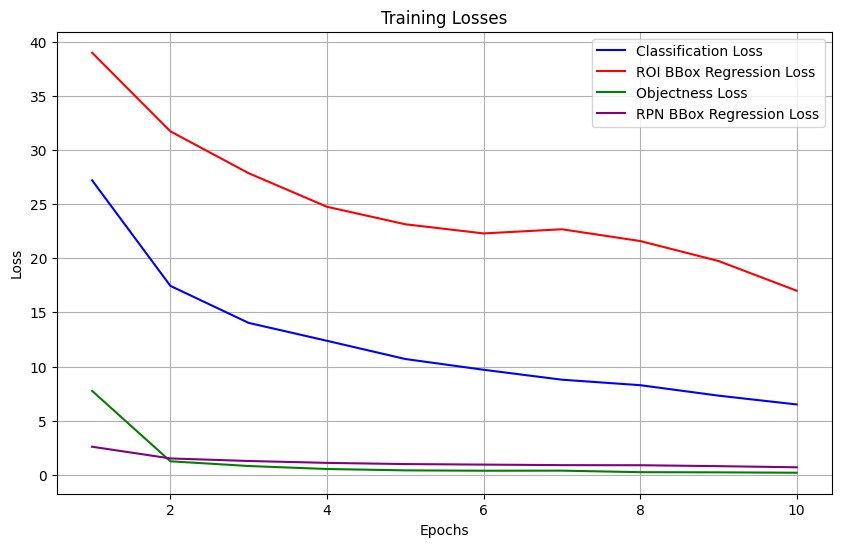

In [ ]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(10, 6))
plt.plot(epochs, classifier_losses, label='Classification Loss', color='blue', linestyle='-')
plt.plot(epochs, bbox_reg_losses, label='ROI BBox Regression Loss', color='red', linestyle='-')
plt.plot(epochs, obj_losses, label='Objectness Loss', color='green', linestyle='-')
plt.plot(epochs, rpn_bbox_losses, label='RPN BBox Regression Loss', color='purple', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')

plt.legend()

plt.grid(True)
plt.show()

Save & Load Model Syntax

    torch.save(model.state_dict(),f'model_trained.pt')
    model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

## 7) Test Model


### 7.1) Create Necessary Functions for Testing

In [ ]:
from torchvision.ops import nms #non-maximum supression

In [ ]:
def make_prediction(model, img, threshold, iou_threshold=0.5):
    model.eval()
    preds = model(img)
    for id in range(len(preds)):
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']):
            #score class prob. of the object in BBox (excluding background class)
            if score > threshold: #if the confidence is low - filter out the detection
                idx_list.append(idx)

        boxes = preds[id]['boxes'][idx_list]
        scores = preds[id]['scores'][idx_list]
        nms_indices = nms(boxes, scores, iou_threshold)
        #For all BBoxes that have an IoU over the threshold, ie overlap by more than 50%
              #take the detection as the box with the highest score, ie classification confidence

        preds[id]['boxes'] = boxes[nms_indices]
        preds[id]['labels'] = preds[id]['labels'][idx_list][nms_indices]
        preds[id]['scores'] = scores[nms_indices]

    return preds

In [ ]:
with torch.no_grad(): #testing - no backprop.
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)
        pred = make_prediction(model, imgs, 0.5)
                              #threshold 50% - accept detection if confidence >= 0.5
        print(pred)
        break

[{'boxes': tensor([[215.9435,  61.3222, 250.9985, 100.6604]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9667], device='cuda:0')}, {'boxes': tensor([[220.1492, 100.4561, 257.1015, 137.9558],
        [133.2898, 110.1221, 179.1643, 152.3610],
        [ 83.6702,  84.4078,  95.0553,  96.4138],
        [305.3819, 131.7706, 331.3308, 158.9371],
        [ 29.9234,  89.0536,  45.1219, 104.2587],
        [ 41.6584, 111.0071,  66.4202, 140.3032],
        [166.1025,  91.6262, 178.9065, 107.4687],
        [  3.7240, 105.9241,  20.6176, 127.3606]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.9947, 0.9803, 0.9692, 0.9549, 0.9422, 0.9237, 0.6977],
       device='cuda:0')}, {'boxes': tensor([[254.9362,  92.5838, 293.5202, 131.3982],
        [ 59.1400, 206.2322, 110.3398, 261.2366],
        [314.8203, 116.4514, 348.8964, 154.0766],
        [181.7182,  76.4728, 213.4720, 109.1819],
        [239.3682, 161.05

In [ ]:
def display_predictions(images, predictions):
    # Define class name mapping
    class_name_mapping = {
        1: 'Without mask',
        2: 'With mask',
        3: 'Mask worn incorrectly'
    }

    # ImageNet mean and std for normalization reversal
    mean = torch.Tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(1)
    std = torch.Tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(1)

    for img, prediction in zip(images, predictions):
        # Revert ImageNet normalization
        img_unnormalized = img.cpu() * std + mean
        # Convert tensor to numpy array and permute axes
        img_np = img_unnormalized.cpu().numpy().transpose(1, 2, 0)  # Change shape to (H, W, C)

        fig, ax = plt.subplots(1)
        ax.imshow(img_np)  # Now the images are in the right format to be displayed

        for idx in range(len(prediction["boxes"])):
            xmin, ymin, xmax, ymax = prediction["boxes"][idx].cpu().numpy()  # Transfer box tensor to CPU and convert to numpy
            label = int(prediction['labels'][idx].cpu().item())  # Convert tensor to integer after transferring to CPU
            score = prediction['scores'][idx].cpu().item()
            class_name = f"{class_name_mapping.get(label, 'Unknown')} {score:.2f}"
            color = None

            if label == 1:
                color = 'r'
            elif label == 2:
                color = 'g'
            elif label == 3:
                color = 'orange'

            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor=color, facecolor='none')
            ax.text(xmin, ymin, class_name, bbox=dict(facecolor=color, alpha=0.5), fontsize=8, color='white')
            ax.add_patch(rect)

        plt.show()


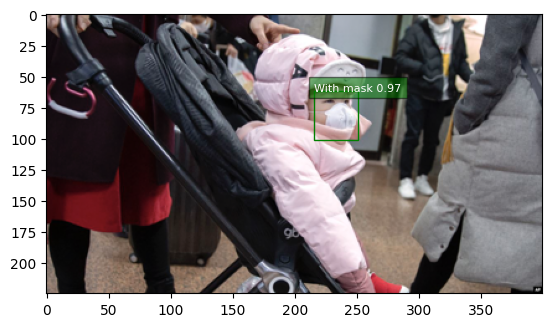

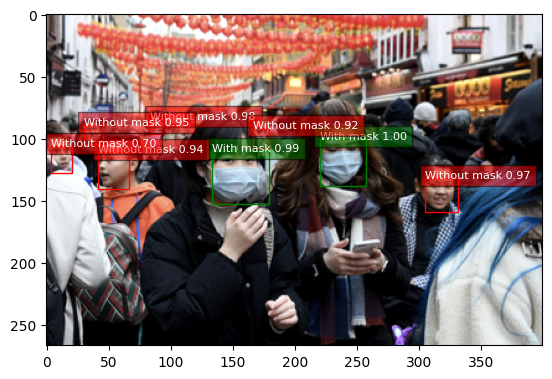

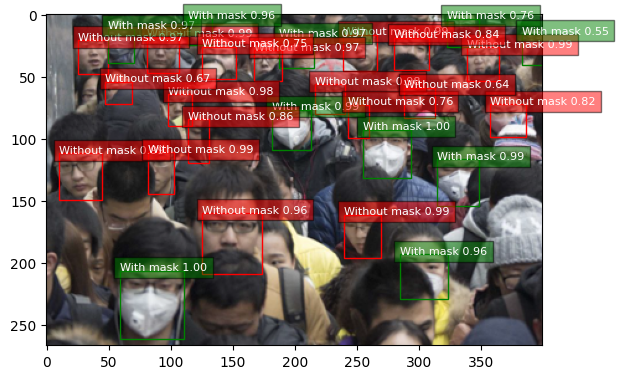

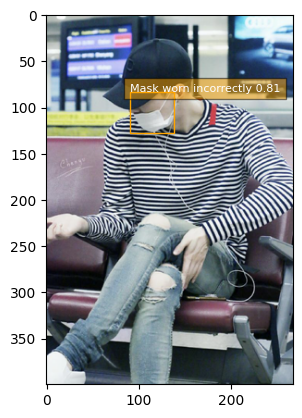

In [ ]:
display_predictions(imgs, pred)

### 7.2) Test Model on the Entire Test Set

In [ ]:
labels = [] #to store GT (actual) labels
preds_adj_all = [] #to store adjusted predictions
annot_all = [] #to store GT annotations

for im, annot in test_data_loader:
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
            #dictionary of model predictions with keys boxes, labels, scores
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics=[]
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)

print("For classes: ",ap_class)
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')
print(f'AP : {AP}')
print(f'mAP : {mAP}')

For classes:  tensor([1, 2, 3])
Precision : tensor([0.8757, 0.9171, 0.8750])
Recall : tensor([0.8000, 0.9409, 0.2692])
F1 Score : tensor([0.8362, 0.9288, 0.4118])
AP : tensor([0.7828, 0.9310, 0.2692], dtype=torch.float64)
mAP : 0.6610378008522559


In [ ]:
def avg_iou(preds_adj_all, annot_all):
    ious = []
    for outputs, targets in zip(preds_adj_all, annot_all):
      #iterates over all predicted - GT annotations
        for sample_i in range(len(outputs)):
          #iterates over each sample in a test batch
            output = outputs[sample_i] #predicted annotations
            annotations = targets[sample_i] #GT annotations
            if not len(annotations):
                continue #skip image if has no objects (GT)
            for pred_box in output['boxes']:
                iou, _ = utils.bbox_iou(pred_box.unsqueeze(0), annotations['boxes']).max(0)
                        #utils from the GitHub repo calculates iou per image
                ious.append(iou.item())
    return sum(ious) / len(ious)

In [ ]:
average_iou = avg_iou(preds_adj_all, annot_all)
print(f"Average IoU: {average_iou:.4f}")

Average IoU: 0.7682
